# **Entrenamiento resnet50**

## Paqueterías:

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import CSVLogger

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import shutil

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.utils import class_weight
from sklearn.utils import resample


In [ ]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")
# Kagglehub does not have a __version__ attribute
print(f"Shutil module is built-in and does not have a version.")
print(f"OS module is built-in and does not have a version.")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
# Sklearn version
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")

TensorFlow version: 2.18.0
Pandas version: 2.2.2
Numpy version: 2.0.2
Seaborn version: 0.13.2
Shutil module is built-in and does not have a version.
OS module is built-in and does not have a version.
Matplotlib version: 3.10.0
Scikit-learn version: 1.6.1


## Descarga dataset

In [ ]:
download_path = kagglehub.dataset_download("rayhanzamzamy/non-and-biodegradable-waste-dataset")
print("Path to downloaded files:", download_path)

dataset_dir = os.path.join(os.getcwd(), "dataset")
os.makedirs(dataset_dir, exist_ok=True)

for item in os.listdir(download_path):
    source = os.path.join(download_path, item)
    destination = os.path.join(dataset_dir, item)
    if os.path.isdir(source):
        shutil.copytree(source, destination, dirs_exist_ok=True)
    else:
        shutil.copy2(source, destination)

shutil.rmtree(download_path)

print(f"Todo el contenido se ha movido a: {dataset_dir}")

100%|██████████| 1.86G/1.86G [00:15<00:00, 133MB/s]

Extracting files...


Path to downloaded files: /root/.cache/kagglehub/datasets/rayhanzamzamy/non-and-biodegradable-waste-dataset/versions/2
Todo el contenido se ha movido a: /content/dataset


## Creación de dataframe

In [ ]:
base_dir = '/content/dataset'
train_dirs = [os.path.join(base_dir, f'TRAIN.{i}') for i in range(1, 5)]

def create_dataframe(train_dirs):
    image_paths = []
    labels = []
    for train_dir in train_dirs:
        for class_name in ['B', 'N']:
            class_dir = os.path.join(train_dir, class_name)
            if not os.path.exists(class_dir):
                continue
            for root, _, files in os.walk(class_dir):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(root, file)
                        image_paths.append(img_path)
                        labels.append(class_name)
    return pd.DataFrame({'filename': image_paths, 'class': labels})

train_df = create_dataframe(train_dirs)

In [ ]:
#Comprobación de creación del dataset
train_df.head()

,filename,class
0,/content/dataset/TRAIN.1/B/TRAIN.1_BIODEG_ORI_...,B
1,/content/dataset/TRAIN.1/B/TRAIN.1_BIODEG_ORI_...,B
2,/content/dataset/TRAIN.1/B/TRAIN.1_BIODEG_ORI_...,B
3,/content/dataset/TRAIN.1/B/TRAIN.1_BIODEG_ORI_...,B
4,/content/dataset/TRAIN.1/B/TRAIN.1_BIODEG_ORI_...,B


In [ ]:
#Comprobación en balanceo de clases
train_df['class'].value_counts()

,count
class,
B,119845
N,119845


## Entrenamiento

In [ ]:
# ====================== DATA PREPARATION ======================
# Balanceo con pesos
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(train_df['class']),
                                                  y=train_df['class'])
class_weights = dict(enumerate(class_weights))

# ====================== DATA GENERATORS ======================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42,
    subset='validation'
)

# ====================== MODEL ARCHITECTURE ======================
def build_resnet():
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base.layers[:140]:
        layer.trainable = False
    for layer in base.layers[140:]:
        layer.trainable = True

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_resnet()

# Callbacks
checkpoint = ModelCheckpoint('predictWaste12.h5',monitor='val_loss',save_best_only=True,mode='min',verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ====================== TRAINING ======================
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=25,
    class_weight=class_weights,
    callbacks=[checkpoint, lr_scheduler, early_stop],
    verbose=1
)

Found 191752 validated image filenames belonging to 2 classes.
Found 47938 validated image filenames belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
5993/5993 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9611 - loss: 0.1096

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5993/5993 ━━━━━━━━━━━━━━━━━━━━ 3726s 616ms/step - accuracy: 0.9611 - loss: 0.1096 - val_accuracy: 0.9796 - val_loss: 0.0563 - learning_rate: 1.0000e-04
Epoch 2/25
5993/5993 ━━━━━━━━━━━━━━━━━━━━ 3646s 608ms/step - accuracy: 0.9816 - loss: 0.0543 - val_accuracy: 0.9848 - val_loss: 0.0439 - learning_rate: 1.0000e-04
Epoch 3/25
5993/5993 ━━━━━━━━━━━━━━━━━━━━ 3581s 597ms/step - accuracy: 0.9868 - loss: 0.0401 - val_accuracy: 0.9862 - val_loss: 0.0411 - learning_rate: 1.0000e-04
Epoch 4/25
5993/5993 ━━━━━━━━━━━━━━━━━━━━ 3661s 604ms/step - accuracy: 0.9888 - loss: 0.0338 - val_accuracy: 0.9879 - val_loss: 0.0347 - learning_rate: 1.0000e-04
Epoch 5/25
5993/5993 ━━━━━━━━━━━━━━━━━━━━ 3565s 595ms/step - accuracy: 0.9911 - loss: 0.0267 - val_accuracy: 0.9879 - val_loss: 0.0353 - learning_rate: 1.0000e-04
Epoch 6/25
3269/5993 ━━━━━━━━━━━━━━━━━━━━ 21:33 475ms/step - accuracy: 0.9919 - loss: 0.0248

# **Pruebas del modelo**



### Carga del modelo:

In [ ]:
model = load_model('/content/drive/MyDrive/Modelos/predictWaste12.h5')

### Cargar y procesar datos de prueba

In [ ]:
test_dir = '/content/dataset/TEST'

In [ ]:
def create_test_dataframe(test_dir):
    image_paths = []
    labels = []
    for class_name in ['B', 'N']:
        class_path = os.path.join(test_dir, class_name)
        if not os.path.exists(class_path):
            continue
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(root, file))
                    labels.append(class_name)
    return pd.DataFrame({'filename': image_paths, 'class': labels})

# Crear el DataFrame de prueba
test_df = create_test_dataframe(test_dir)

# Verifica el resultado
print(test_df.sample(5))
print(f"Total de imágenes de prueba: {len(test_df)}")
print(test_df['class'].value_counts())

                                                filename class
15547  /content/dataset/TEST/N/TEST_NBIODEG_ORI_7016.jpg     N
10134  /content/dataset/TEST/N/TEST_NBIODEG_ORI_4140.jpg     N
11112  /content/dataset/TEST/N/TEST_NBIODEG_ORI_1010.jpg     N
11132  /content/dataset/TEST/N/TEST_NBIODEG_ORI_3468.jpg     N
6100    /content/dataset/TEST/B/TEST_BIODEG_ROT_1781.jpg     B
Total de imágenes de prueba: 16726
class
B    8363
N    8363
Name: count, dtype: int64


In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Importante para mantener el orden
)

Found 16726 validated image filenames belonging to 2 classes.


In [ ]:
print("Distribución de clases en el generador de validación:")
print(np.unique(test_generator.classes, return_counts=True))

Distribución de clases en el generador de validación:
(array([0, 1]), array([8363, 8363]))


### Predicciones

In [ ]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy en validación: {acc:.4f}")

# Reporte completo
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


523/523 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step
Accuracy en validación: 0.9249

Reporte de clasificación:
              precision    recall  f1-score   support

           B       0.98      0.87      0.92      8363
           N       0.88      0.98      0.93      8363

    accuracy                           0.92     16726
   macro avg       0.93      0.92      0.92     16726
weighted avg       0.93      0.92      0.92     16726



**La precision**: indica el porcentaje de veces que el modelo predijo correctamente una clase entre todas las veces que predijo esa clase.

**El recall**: mide la capacidad del modelo para encontrar todos los casos reales de una clase.

**El f1-score**: es una métrica balanceada que combina precision y recall, útil cuando hay que encontrar un equilibrio entre falsos positivos y falsos negativos.

**El support**: representa la cantidad de ejemplos reales de cada clase utilizados para evaluar el modelo, siendo 8363 para ambas.

**La accuracy global**: del modelo es del 92%, lo que significa que acertó en 92 de cada 100 predicciones. Por otro lado, las métricas macro avg y weighted avg promedian los resultados de ambas clases: la macro lo hace de forma uniforme, sin importar cuántos ejemplos haya de cada clase, y la weighted toma en cuenta la cantidad de datos por clase. Ambas coinciden en valores similares (precision: 0.93, recall: 0.92, f1-score: 0.92), lo que sugiere que el modelo es consistente en su rendimiento.

### Matriz de confusión

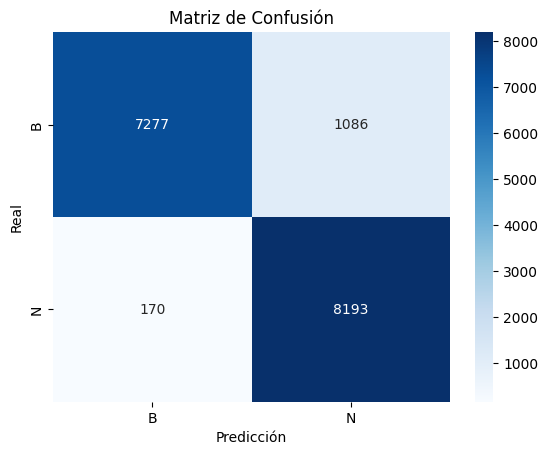

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### Prueba Roc y AUC

❓ ¿Por qué hay errores si el AUC es alto?

Porque **ningún modelo es perfecto**. Aunque el AUC (Área bajo la curva ROC) sea alto, el modelo aún puede confundirse en ciertos casos. El AUC nos indica el rendimiento promedio del modelo para distinguir entre clases, pero no garantiza que todos los casos serán clasificados correctamente.

> **"Tu modelo, en promedio, es muy bueno discriminando entre ambas clases."**

---

 📊 Interpretación del AUC:

- **AUC = 1.0** → Modelo perfecto.  
- **AUC entre 0.9 y 0.99** → Excelente rendimiento.  
- **AUC entre 0.8 y 0.9** → Buen rendimiento.  
- **AUC ≈ 0.5** → No mejor que el azar.

---

 ⚽ Analogía:

Imagina que el modelo es un **portero en un equipo de fútbol**.  
El AUC mide **qué tan buen portero es en promedio**, es decir, cuántos tiros detiene correctamente.

Sin embargo, eso **no significa que nunca le metan goles**.  
Solo indica que, en la mayoría de los casos, **hace bien su trabajo**.

Así funciona el modelo: puede tener un AUC excelente y aún cometer errores puntuales.


In [ ]:
test_generator.reset()
y_true = test_generator.classes
y_scores = model.predict(test_generator, steps=len(test_generator))

y_scores = y_scores[:, 1]  # Probabilidad de pertenecer a la clase 1

523/523 ━━━━━━━━━━━━━━━━━━━━ 53s 101ms/step


In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

AUC: 0.9846


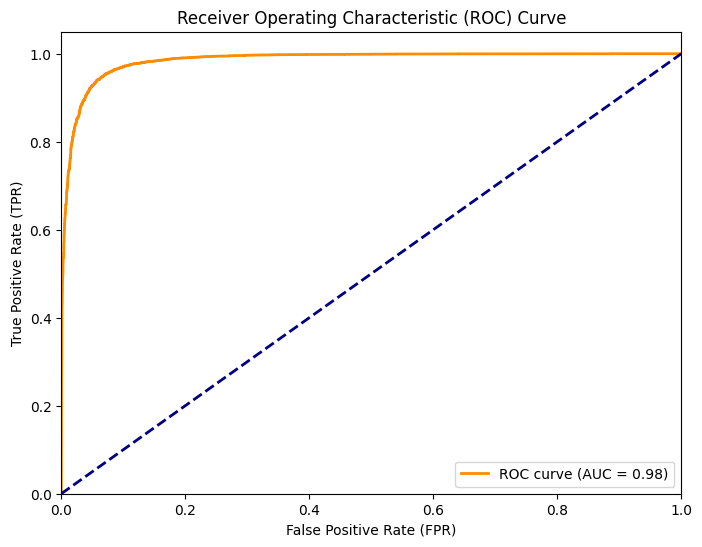

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia (azar)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## **Conclusión del análisis realizado**

El modelo de clasificación basado en **ResNet50** ha demostrado un rendimiento excelente en pruebas controladas, alcanzando métricas superiores al 98 % de precisión y un AUC de 0.9846. Sin embargo, si se presentan errores en la clasificación en tiempo real, es importante considerar que estos no se deben necesariamente a fallos del modelo, sino a factores externos como los siguientes:


*   **Calidad de la cámara**: Cámaras con baja resolución, sensores deficientes o enfoque incorrecto pueden comprometer la claridad de los objetos a clasificar.
*   **Condiciones de iluminación**: Iluminación inconsistente, sombras, reflejos o luz insuficiente pueden alterar los colores y texturas percibidos por la IA, afectando la predicción.
*   **Ángulo de visión**: Si el objeto no se encuentra completamente centrado o se presenta en una orientación distinta a las vistas del entrenamiento, el modelo puede obtener información incompleta.
*   **Captura del frame en mal momento**: Si la imagen es capturada mientras el objeto está en movimiento o parcialmente visible, la predicción puede no ser precisa.
*   **Contexto diferente al entrenamiento**: El modelo fue entrenado con imágenes limpias, bien centradas y bajo condiciones controladas. Su desempeño puede disminuir si el entorno real difiere sustancialmente.

Recomendación: Para un funcionamiento óptimo del sistema, se sugiere utilizar una cámara de al menos 5 MP con enfoque fijo, iluminación uniforme (idealmente mediante LEDs), y posicionar la cámara en un ángulo constante que asegure una vista clara del objeto. Además, implementar un retardo de 3–5 segundos antes de capturar la imagen permite asegurar que el objeto esté bien posicionado.

En caso de que el sistema continúe fallando aún con una cámara mejor y condiciones óptimas, se procederá a una revisión profunda del dataset utilizado para entrenar el modelo, con el fin de detectar posibles sesgos, clases mal etiquetadas, desbalance oculto o imágenes poco representativas del entorno real.

# **Cambio de modelo**


## **Análisis y Solución de Sesgo en el Modelo de Clasificación**

Tras una exhaustiva verificación, como se menciono anterior se verifico tanto como la cámara como el modelo y se ha identificado un sesgo significativo en el modelo de clasificación. Este sesgo se origina en el conjunto de datos de entrenamiento (**dataset**) original, que estaba compuesto predominantemente por imágenes de stock. Este factor ha limitado la capacidad del modelo para generalizar y reconocer correctamente imágenes en entornos de tiempo real. Los intentos de detección, incluso al aplicar la estrategia de análisis multiframe, han resultado en clasificaciones erróneas debido a que el modelo no fue entrenado con la diversidad y las características de imágenes del mundo real.

### **Propuesta de Solución**

Para mitigar este problema y mejorar la precisión del sistema, se proponen las siguientes acciones:

* **Creación y curación de un nuevo dataset:** Se construirá un nuevo conjunto de datos a partir de colecciones de fotografías de residuos de uso libre. Estas imágenes se reclasificarán minuciosamente en las dos categorías de interés: **biodegradable** y **no biodegradable**.
* **Actualización del modelo preentrenado:** Se reemplazará el modelo preentrenado actual, **ResNet50**, por la versión más reciente de **MobileNetV2**. Este modelo es conocido por su eficiencia y su capacidad para operar en entornos con recursos limitados, lo que lo hace ideal para aplicaciones en tiempo real.

In [ ]:
base_dir = '/content/drive/MyDrive/Dataset personalizado'

def creadorDataFrame(base_dir):
    image_paths = []
    labels = []
    for class_name in ['B', 'N']:
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Advertencia: Directorio {class_dir} no encontrado")
            continue
        for root, _, files in os.walk(class_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(root, file)
                    image_paths.append(img_path)
                    labels.append(class_name)
    return pd.DataFrame({'filename': image_paths, 'class': labels})
dfEntrenamiento = creadorDataFrame(base_dir)

print(f"Total de imágenes: {len(dfEntrenamiento)}")
print(f"Distribución de clases:\n{dfEntrenamiento['class'].value_counts()}")

Total de imágenes: 7142
Distribución de clases:
class
N    4019
B    3123
Name: count, dtype: int64


In [ ]:
#Submuestreo (Downsampling)

df_N = dfEntrenamiento[dfEntrenamiento['class'] == 'N']
df_B = dfEntrenamiento[dfEntrenamiento['class'] == 'B']

df_N_downsampled = resample(df_N,replace=False,n_samples=len(df_B),random_state=42)

df_balanced = pd.concat([df_N_downsampled, df_B])

print(f"Total después de balanceo: {len(df_balanced)}")
print(f"Distribución balanceada:\n{df_balanced['class'].value_counts()}")

Total después de balanceo: 6246
Distribución balanceada:
class
N    3123
B    3123
Name: count, dtype: int64


In [ ]:
# ====================== DATA PREPARATION ======================
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(df_balanced['class']), y=df_balanced['class'])
class_weights = dict(enumerate(class_weights))

# ====================== DATA GENERATORS ======================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    #rotation_range=25,
    #width_shift_range=0.15,
    #height_shift_range=0.15,
    zoom_range=0.2,
    #brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42,
    subset='validation'
)

# ====================== MODEL ARCHITECTURE ======================
def build_mobilenetv2():
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')  # GlobalAveragePooling2D incluido
    base.trainable = False
    #for layer in base.layers[:-30]:  # Congelar todas excepto las últimas 30 capas
         #layer.trainable = False

    x = base.output
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_mobilenetv2()

# Callbacks
checkpoint = ModelCheckpoint('predictWaste_mobilenetv2.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# ====================== TRAINING ======================


history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=35,
    class_weight=class_weights,
    callbacks=[checkpoint, lr_scheduler, early_stop],
    verbose=1
)

Found 4997 validated image filenames belonging to 2 classes.
Found 1249 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6136 - loss: 0.8543 
Epoch 1: val_loss improved from inf to 0.65872, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 2087s 13s/step - accuracy: 0.6138 - loss: 0.8538 - val_accuracy: 0.6373 - val_loss: 0.6587 - learning_rate: 1.0000e-04
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7037 - loss: 0.6463
Epoch 2: val_loss improved from 0.65872 to 0.60810, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 132s 585ms/step - accuracy: 0.7038 - loss: 0.6462 - val_accuracy: 0.6918 - val_loss: 0.6081 - learning_rate: 1.0000e-04
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7468 - loss: 0.5697
Epoch 3: val_loss improved from 0.60810 to 0.55325, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 92s 584ms/step - accuracy: 0.7467 - loss: 0.5697 - val_accuracy: 0.7198 - val_loss: 0.5533 - learning_rate: 1.0000e-04
Epoch 4/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.7524 - loss: 0.5440
Epoch 4: val_loss improved from 0.55325 to 0.52024, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 95s 606ms/step - accuracy: 0.7524 - loss: 0.5440 - val_accuracy: 0.7534 - val_loss: 0.5202 - learning_rate: 1.0000e-04
Epoch 5/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7639 - loss: 0.5311
Epoch 5: val_loss did not improve from 0.52024
157/157 ━━━━━━━━━━━━━━━━━━━━ 136s 570ms/step - accuracy: 0.7639 - loss: 0.5310 - val_accuracy: 0.7526 - val_loss: 0.5304 - learning_rate: 1.0000e-04
Epoch 6/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7806 - loss: 0.4857
Epoch 6: val_loss did not improve from 0.52024
157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 580ms/step - accuracy: 0.7806 - loss: 0.4857 - val_accuracy: 0.7430 - val_loss: 0.5272 - learning_rate: 1.0000e-04
Epoch 7/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7736 - loss: 0.4991
Epoch 7: val_loss improved from 0.52024 to 0.50829, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 580ms/step - accuracy: 0.7736 - loss: 0.4990 - val_accuracy: 0.7462 - val_loss: 0.5083 - learning_rate: 1.0000e-04
Epoch 8/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7902 - loss: 0.4676
Epoch 8: val_loss did not improve from 0.50829
157/157 ━━━━━━━━━━━━━━━━━━━━ 143s 587ms/step - accuracy: 0.7902 - loss: 0.4676 - val_accuracy: 0.7438 - val_loss: 0.5243 - learning_rate: 1.0000e-04
Epoch 9/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7920 - loss: 0.4704
Epoch 9: val_loss improved from 0.50829 to 0.50286, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 576ms/step - accuracy: 0.7920 - loss: 0.4704 - val_accuracy: 0.7630 - val_loss: 0.5029 - learning_rate: 1.0000e-04
Epoch 10/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7981 - loss: 0.4480
Epoch 10: val_loss improved from 0.50286 to 0.49269, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 92s 590ms/step - accuracy: 0.7982 - loss: 0.4480 - val_accuracy: 0.7774 - val_loss: 0.4927 - learning_rate: 1.0000e-04
Epoch 11/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8087 - loss: 0.4246
Epoch 11: val_loss did not improve from 0.49269
157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 575ms/step - accuracy: 0.8087 - loss: 0.4245 - val_accuracy: 0.7630 - val_loss: 0.5142 - learning_rate: 1.0000e-04
Epoch 12/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.8050 - loss: 0.4394
Epoch 12: val_loss improved from 0.49269 to 0.48417, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 90s 574ms/step - accuracy: 0.8051 - loss: 0.4393 - val_accuracy: 0.7798 - val_loss: 0.4842 - learning_rate: 1.0000e-04
Epoch 13/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8134 - loss: 0.4241
Epoch 13: val_loss improved from 0.48417 to 0.46931, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 577ms/step - accuracy: 0.8133 - loss: 0.4241 - val_accuracy: 0.7766 - val_loss: 0.4693 - learning_rate: 1.0000e-04
Epoch 14/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8152 - loss: 0.4097
Epoch 14: val_loss did not improve from 0.46931
157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 578ms/step - accuracy: 0.8152 - loss: 0.4097 - val_accuracy: 0.7886 - val_loss: 0.4730 - learning_rate: 1.0000e-04
Epoch 15/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8091 - loss: 0.4055
Epoch 15: val_loss improved from 0.46931 to 0.46476, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 92s 587ms/step - accuracy: 0.8091 - loss: 0.4054 - val_accuracy: 0.7798 - val_loss: 0.4648 - learning_rate: 1.0000e-04
Epoch 16/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8352 - loss: 0.3812
Epoch 16: val_loss did not improve from 0.46476
157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 580ms/step - accuracy: 0.8351 - loss: 0.3813 - val_accuracy: 0.7670 - val_loss: 0.4946 - learning_rate: 1.0000e-04
Epoch 17/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8149 - loss: 0.4000
Epoch 17: val_loss did not improve from 0.46476
157/157 ━━━━━━━━━━━━━━━━━━━━ 143s 586ms/step - accuracy: 0.8149 - loss: 0.3999 - val_accuracy: 0.7862 - val_loss: 0.4711 - learning_rate: 1.0000e-04
Epoch 18/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8289 - loss: 0.3847
Epoch 18: val_loss did not improve from 0.46476

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 577ms/step - accuracy: 0.8289 - l

157/157 ━━━━━━━━━━━━━━━━━━━━ 143s 583ms/step - accuracy: 0.8288 - loss: 0.3735 - val_accuracy: 0.7798 - val_loss: 0.4625 - learning_rate: 5.0000e-05
Epoch 20/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8304 - loss: 0.3775
Epoch 20: val_loss improved from 0.46248 to 0.45509, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 143s 589ms/step - accuracy: 0.8304 - loss: 0.3775 - val_accuracy: 0.8054 - val_loss: 0.4551 - learning_rate: 5.0000e-05
Epoch 21/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8413 - loss: 0.3583
Epoch 21: val_loss improved from 0.45509 to 0.44295, saving model to predictWaste_mobilenetv2.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 93s 594ms/step - accuracy: 0.8413 - loss: 0.3584 - val_accuracy: 0.7894 - val_loss: 0.4430 - learning_rate: 5.0000e-05
Epoch 22/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8380 - loss: 0.3494
Epoch 22: val_loss did not improve from 0.44295
157/157 ━━━━━━━━━━━━━━━━━━━━ 91s 584ms/step - accuracy: 0.8380 - loss: 0.3494 - val_accuracy: 0.7838 - val_loss: 0.4761 - learning_rate: 5.0000e-05
Epoch 23/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8366 - loss: 0.3663
Epoch 23: val_loss did not improve from 0.44295
157/157 ━━━━━━━━━━━━━━━━━━━━ 92s 585ms/step - accuracy: 0.8367 - loss: 0.3662 - val_accuracy: 0.7870 - val_loss: 0.4890 - learning_rate: 5.0000e-05
Epoch 24/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8409 - loss: 0.3569
Epoch 24: val_loss did not improve from 0.44295

Epoch 24: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
157/157 ━━━━━━━━━━━━━━━━━━━━ 138s 558ms/step - accuracy: 0.8409 - l

# Pruebas MobileNet V2

### Carga del modelo

In [2]:
model = load_model('/content/drive/MyDrive/Modelos/predictWaste_mobilenetv2.h5')

### Cargar y procesar datos de prueba

In [6]:
download_path = kagglehub.dataset_download("northphilcadag/waste-image-dataset-for-cnn-capstone-v3-march-2")
print("Path to downloaded files:", download_path)

dataset_dir = os.path.join(os.getcwd(), "dataset")
os.makedirs(dataset_dir, exist_ok=True)

for item in os.listdir(download_path):
    source = os.path.join(download_path, item)
    destination = os.path.join(dataset_dir, item)
    if os.path.isdir(source):
        shutil.copytree(source, destination, dirs_exist_ok=True)
    else:
        shutil.copy2(source, destination)

shutil.rmtree(download_path)

print(f"Todo el contenido se ha movido a: {dataset_dir}")

100%|██████████| 250M/250M [00:02<00:00, 113MB/s]

Extracting files...


Path to downloaded files: /root/.cache/kagglehub/datasets/northphilcadag/waste-image-dataset-for-cnn-capstone-v3-march-2/versions/1
Todo el contenido se ha movido a: /content/dataset


In [7]:
test_dir = '/content/dataset/Waste_Image_Dataset_for_CNN_AI_Model_Capstone_Group_4_Flat'

In [8]:
def create_test_dataframe(test_dir):
    image_paths = []
    labels = []
    for class_name in ['B', 'N']:
        class_path = os.path.join(test_dir, class_name)
        if not os.path.exists(class_path):
            continue
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(root, file))
                    labels.append(class_name)
    return pd.DataFrame({'filename': image_paths, 'class': labels})

# Crear el DataFrame de prueba
test_df = create_test_dataframe(test_dir)

# Verifica el resultado
print(test_df.sample(5))
print(f"Total de imágenes de prueba: {len(test_df)}")
print(test_df['class'].value_counts())

                                                filename class
27054  /content/dataset/Waste_Image_Dataset_for_CNN_A...     N
7448   /content/dataset/Waste_Image_Dataset_for_CNN_A...     B
19522  /content/dataset/Waste_Image_Dataset_for_CNN_A...     N
27489  /content/dataset/Waste_Image_Dataset_for_CNN_A...     N
29677  /content/dataset/Waste_Image_Dataset_for_CNN_A...     N
Total de imágenes de prueba: 30064
class
N    15249
B    14815
Name: count, dtype: int64


In [10]:
df_N = test_df[test_df['class'] == 'N']
df_B = test_df[test_df['class'] == 'B']

df_N_downsampled = resample(df_N,replace=False,n_samples=len(df_B),random_state=42)

df_balanced = pd.concat([df_N_downsampled, df_B])

print(f"Total después de balanceo: {len(df_balanced)}")
print(f"Distribución balanceada:\n{df_balanced['class'].value_counts()}")

Total después de balanceo: 29630
Distribución balanceada:
class
N    14815
B    14815
Name: count, dtype: int64


In [11]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Importante para mantener el orden
)

Found 29630 validated image filenames belonging to 2 classes.


In [12]:
print("Distribución de clases en el generador de validación:")
print(np.unique(test_generator.classes, return_counts=True))

Distribución de clases en el generador de validación:
(array([0, 1]), array([14815, 14815]))


### Predicciones

In [15]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy en validación: {acc:.4f}")

# Reporte completo
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

926/926 ━━━━━━━━━━━━━━━━━━━━ 53s 57ms/step
Accuracy en validación: 0.5413

Reporte de clasificación:
              precision    recall  f1-score   support

           B       0.52      0.89      0.66     14815
           N       0.64      0.19      0.29     14815

    accuracy                           0.54     29630
   macro avg       0.58      0.54      0.48     29630
weighted avg       0.58      0.54      0.48     29630



### Matriz de confusión

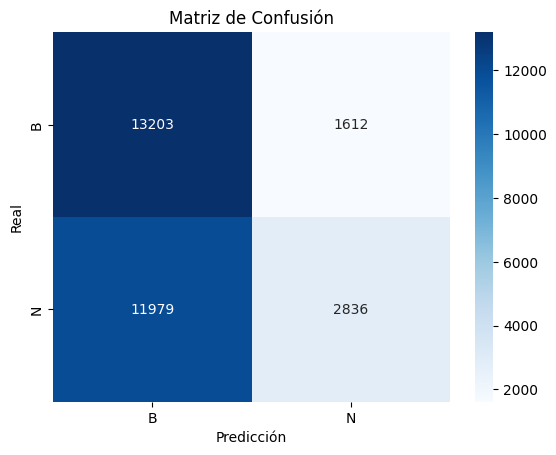

In [20]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### Prueba Roc y AUC

In [17]:
test_generator.reset()
y_true = test_generator.classes
y_scores = model.predict(test_generator, steps=len(test_generator))

y_scores = y_scores[:, 1]  # Probabilidad de pertenecer a la clase 1

926/926 ━━━━━━━━━━━━━━━━━━━━ 49s 53ms/step


In [18]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

AUC: 0.5663


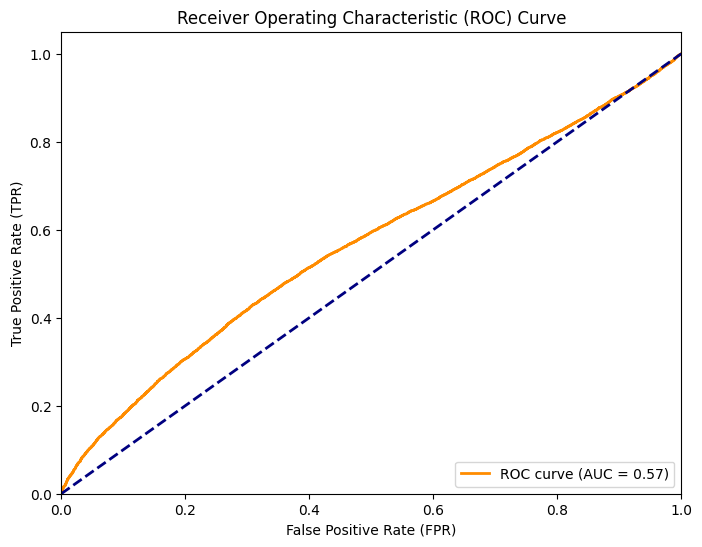

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia (azar)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()